In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import tensorflow as tf
keras = tf.keras
K = keras.backend

from resnet import Resnet18
from model import BiSeNet

In [2]:
def load_pytorch_model(save_path=os.path.join("res/cp", "79999_iter.pth"),
                       n_classes=19):
    net = BiSeNet(n_classes=n_classes)
#     net.cuda()
    
    net.load_state_dict(torch.load(save_path))
#     net.eval()

    return net

## Convert Resnet18

In [3]:
net = Resnet18()
net = net.eval()

x = torch.randn(16, 3, 224, 224)
out = net(x)
print(out[0].size())
print(out[1].size())
print(out[2].size())

torch.Size([16, 128, 28, 28])
torch.Size([16, 256, 14, 14])
torch.Size([16, 512, 7, 7])


In [4]:
net

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [5]:
def filter_dict_by_name(name, state_dict):
    return dict(filter(lambda t: t[0].startswith(name + "."),  state_dict.items()))


def strip_dict_key_prefix(state_dict, cut=1):
    """Strip parameter key prefix."""
    return {f"{'.'.join(k.split('.')[cut:])}": v for k, v in state_dict.items()}


def conv2d_weights_pth2tf(params_dict):
    """Convert conv2d weights from Pytorch to TensorFlow."""
    
    weights = []
    
    # gamma, beta, moving_mean, moving_variance
    for key in ["weight", "bias"]:
        if key not in params_dict:
            continue
            
        if key == "weight":
            weights.append(np.transpose(params_dict[key].detach().cpu().numpy(), [2, 3, 1, 0]))
        else:
            weights.append(params_dict[key].detach().cpu().numpy())
    
    return weights


def bn_weights_pth2tf(params_dict):
    """Convert batch norm weights from Pytorch to TensorFlow."""
    
    weights = []
    
    # gamma, beta, moving_mean, moving_variance
    for key in ["weight", "bias", "running_mean", "running_var"]:
        weights.append(params_dict[key].detach().cpu().numpy())
    
    return weights


def get_weight_conversion_fn(layer):
    """Get the appropriate weight conversion function given the layer."""
    
    if isinstance(layer, keras.layers.Conv2D):
        fn = conv2d_weights_pth2tf
    elif isinstance(layer, keras.layers.BatchNormalization):
        fn = bn_weights_pth2tf
    else:
        raise Exception(f"Unknown layer type: {type(layer)}")
        
    return fn


def th2tf_conv(prefix, state_dict):
    w = state_dict.get(f'{prefix}.weight')
    b = state_dict.get(f'{prefix}.bias', None)
    weights = [w.permute(2, 3, 1, 0).detach().cpu().numpy(), ]
    if b is not None: weights += [b.detach().cpu().numpy(), ]
    return weights

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return keras.layers.Conv2D(
#         in_planes,
        out_planes,
        kernel_size=3,
        strides=stride,
        padding="same",
        use_bias=False
    )


class BasicBlock(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(in_chan, out_chan, stride)
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = conv3x3(out_chan, out_chan)
        self.bn2 = keras.layers.BatchNormalization()
#         self.relu = nn.ReLU(inplace=True)
        self.relu = keras.activations.relu
    
        self.downsample = None
        if in_chan != out_chan or stride != 1:
            self.downsample = keras.models.Sequential()
            self.downsample.add(
                keras.layers.Conv2D(
#                     in_chan, 
                    out_chan,
                    kernel_size=1, 
                    strides=stride, 
                    use_bias=False
                )
            )
            self.downsample.add(
                keras.layers.BatchNormalization()
            )

    def call(self, x, training=None):
        residual = self.conv1(x)
        residual = self.relu(self.bn1(residual, training=training))
        residual = self.conv2(residual)
        residual = self.bn2(residual, training=training)

        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)

        out = shortcut + residual
        out = self.relu(out)
        return out
    
    def load_weigths_pytorch(self, state_dict):
        for layer_name in [
            "conv1",
            "bn1",
            "conv2",
            "bn2",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)

            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}")
#             print(layer_state_dict)
            layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
    
        print()
    
        if self.downsample:
            print(f"{self.__class__.__name__}: self.downsample not None...")
            
            for idx, layer in enumerate(self.downsample.layers):
                print(f"{self.__class__.__name__}: \tidx: {idx}, layer type: {layer.__class__.__name__}")

                layer_state_dict = filter_dict_by_name(f"downsample.{idx}", state_dict)
                layer_state_dict = strip_dict_key_prefix(layer_state_dict, cut=2)
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))


def create_layer_basic(in_chan, out_chan, bnum, stride=1):
    model = keras.models.Sequential()
    model.add(BasicBlock(in_chan, out_chan, stride=stride))
    for i in range(bnum - 1):
        model.add(BasicBlock(out_chan, out_chan, stride=1))
    return model


class TFResnet18(keras.models.Model):
    def __init__(self):
        super(TFResnet18, self).__init__()
        
        self.conv1 = keras.layers.Conv2D(
#             3, 
            64, 
            kernel_size=7, 
            strides=2, 
            padding="same",
            use_bias=False
        )
        self.bn1 = keras.layers.BatchNormalization()
        self.maxpool = keras.layers.MaxPool2D(3, strides=2, padding="same")
        self.layer1 = create_layer_basic(64, 64, bnum=2, stride=1)
        self.layer2 = create_layer_basic(64, 128, bnum=2, stride=2)
        self.layer3 = create_layer_basic(128, 256, bnum=2, stride=2)
        self.layer4 = create_layer_basic(256, 512, bnum=2, stride=2)

    def call(self, x, training=None):
        x = self.conv1(x)
        x = K.relu(self.bn1(x, training=training))
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        feat8 = self.layer2(x, training=training) # 1/8
        feat16 = self.layer3(feat8, training=training) # 1/16
        feat32 = self.layer4(feat16, training=training) # 1/32
        return feat8, feat16, feat32
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in ["conv1", "bn1"]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")
            layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            
        print()
        
        for seq_layer_name in [f"layer{i+1}" for i in range(4)]:
            seq_layer = getattr(self, seq_layer_name)
    
            print(f"{self.__class__.__name__}: Sequential layer: {seq_layer_name}")
            
            for idx, layer in enumerate(seq_layer.layers):
                print(f"{self.__class__.__name__}: \tidx: {idx}, layer type: {layer.__class__.__name__}")

                layer_state_dict = filter_dict_by_name(f"{seq_layer_name}.{idx}", state_dict)
                layer_state_dict = strip_dict_key_prefix(layer_state_dict, cut=2)
    #             print(layer_state_dict)
                layer.load_weigths_pytorch(layer_state_dict)
        
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [7]:
net_tf = TFResnet18()
x = tf.random.normal((16, 224, 224, 3))
out = net_tf(x)
print(out[0].shape)
print(out[1].shape)
print(out[2].shape)

(16, 28, 28, 128)
(16, 14, 14, 256)
(16, 7, 7, 512)


In [8]:
net_tf.summary()

Model: "tf_resnet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9408      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  148480    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  526848    
_________________________________________________________________
sequential_3 (Sequential)    multiple                  2102272   
_________________________________________________________________
sequential_5 (Sequential)    multiple                  

In [9]:
resnet18_state_dict = torch.load("resnet18-5c106cde.pth")

In [10]:
net_tf.load_weights_pytorch(resnet18_state_dict)

TFResnet18: Setting weight for layer: conv1, type: Conv2D
TFResnet18: layer_state_dict keys: ['weight']
TFResnet18: Setting weight for layer: bn1, type: BatchNormalization
TFResnet18: layer_state_dict keys: ['running_mean', 'running_var', 'weight', 'bias']

TFResnet18: Sequential layer: layer1
TFResnet18: 	idx: 0, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
BasicBlock: Setting weight for layer: bn2

TFResnet18: 	idx: 1, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
BasicBlock: Setting weight for layer: bn2

TFResnet18: Sequential layer: layer2
TFResnet18: 	idx: 0, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
BasicBlock: Setting weight for layer: bn2

BasicBlock: self.

In [11]:
list(resnet18_state_dict.keys())

['conv1.weight',
 'bn1.running_mean',
 'bn1.running_var',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.running_mean',
 'layer1.0.bn1.running_var',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.running_mean',
 'layer1.0.bn2.running_var',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.running_mean',
 'layer1.1.bn1.running_var',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.running_mean',
 'layer1.1.bn2.running_var',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.running_mean',
 'layer2.0.bn1.running_var',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.running_mean',
 'layer2.0.bn2.running_var',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.running_mean',
 'layer2.0.downsample.1.running_var',
 'layer2.0.downsam

In [12]:
list(net.state_dict().keys())

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'bn1.running_mean',
 'bn1.running_var',
 'bn1.num_batches_tracked',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.bn1.running_mean',
 'layer1.0.bn1.running_var',
 'layer1.0.bn1.num_batches_tracked',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.0.bn2.running_mean',
 'layer1.0.bn2.running_var',
 'layer1.0.bn2.num_batches_tracked',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.bn1.running_mean',
 'layer1.1.bn1.running_var',
 'layer1.1.bn1.num_batches_tracked',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer1.1.bn2.running_mean',
 'layer1.1.bn2.running_var',
 'layer1.1.bn2.num_batches_tracked',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.bn1.running_mean',
 'layer2.0.bn1.running_var',
 'layer2.0.bn1.num_batches_tracked',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weigh

In [13]:
net.load_state_dict(resnet18_state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])

In [14]:
conv1_tf = keras.layers.Conv2D(
#             3,
            64,
            kernel_size=7,
            strides=2,
            padding="same",
            use_bias=False
        )

In [15]:
conv1 = torch.nn.Conv2d(
    3, 
    64, 
    kernel_size=7, 
    stride=2, 
    padding=3, bias=False)

In [16]:
conv1_state_dict = conv1.state_dict()

In [17]:
conv1_state_dict.keys()

odict_keys(['weight'])

In [18]:
conv1.load_state_dict(
    conv1_state_dict
)

<All keys matched successfully>

In [19]:
conv1.eval()

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [20]:
fixed_input = np.random.rand(16, 224, 224, 3).astype(np.float32)

In [21]:
conv1_tf(fixed_input)

<tf.Tensor: shape=(16, 112, 112, 64), dtype=float32, numpy=
array([[[[-2.74625301e-01,  6.17659949e-02,  1.06609493e-01, ...,
          -5.34324422e-02, -1.99761197e-01,  1.02210734e-02],
         [-1.90443426e-01,  1.40880302e-01,  2.41858028e-02, ...,
          -9.66662019e-02, -2.52769769e-05, -2.02077284e-01],
         [-2.47439623e-01,  4.25829627e-02,  3.22359279e-02, ...,
          -1.08215779e-01,  5.83513863e-02, -9.58744884e-02],
         ...,
         [-8.54791179e-02, -8.78806859e-02,  4.77685966e-02, ...,
          -1.48105279e-01, -8.23233053e-02, -2.68999755e-01],
         [-1.67300284e-01,  1.63508523e-02,  9.20394585e-02, ...,
          -3.19413729e-02, -1.56775825e-02, -1.23137809e-01],
         [ 5.88630177e-02,  6.14729449e-02,  8.25525746e-02, ...,
          -3.77465002e-02,  1.02806382e-01, -2.33944580e-01]],

        [[-6.87389225e-02,  5.02389520e-02, -1.04770213e-02, ...,
          -1.06464140e-01, -1.93767235e-01, -4.89195585e-02],
         [-6.14800192e-02, -

In [22]:
conv1_tf.set_weights(
    get_weight_conversion_fn(conv1_tf)(
        conv1_state_dict
    )
)

In [23]:
conv1.training

False

In [24]:
conv1_out = conv1(torch.from_numpy(fixed_input).permute(0, 3, 1, 2)) \
                .permute(0, 2, 3, 1) \
                .detach() \
                .numpy()

In [25]:
conv1_out.shape

(16, 112, 112, 64)

In [26]:
conv1_out_tf = conv1_tf(fixed_input)\
                .numpy()

In [27]:
conv1_out_tf.shape

(16, 112, 112, 64)

In [28]:
np.allclose(conv1_out, conv1_out_tf)

False

In [29]:
random_idx = np.random.randint(0, 64-3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


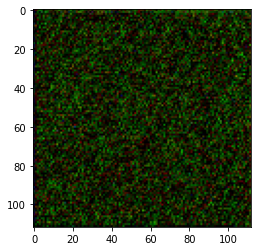

In [30]:
plt.imshow(conv1_out[0][..., random_idx:random_idx+3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


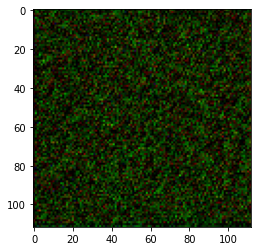

In [31]:
plt.imshow(conv1_out_tf[0][..., random_idx:random_idx+3])

In [32]:
conv1_out

array([[[[-2.40213290e-01, -1.47098064e-01,  7.93523043e-02, ...,
           1.59389272e-01, -9.73844230e-02, -5.21955118e-02],
         [ 7.20755905e-02,  2.01631784e-01,  2.01606497e-01, ...,
           1.88771605e-01, -3.09004635e-01, -3.35449725e-01],
         [-7.32221901e-02,  9.04513299e-02,  1.08049311e-01, ...,
           3.13674003e-01, -3.07218302e-02, -2.50556082e-01],
         ...,
         [-9.55455303e-02,  1.35543212e-01,  2.77399063e-01, ...,
           5.49318969e-01, -2.98170805e-01, -2.60427713e-01],
         [-1.04407810e-01, -3.20507996e-02,  3.21237683e-01, ...,
           4.97489035e-01, -3.52308989e-01, -2.15586126e-01],
         [-2.40363061e-01,  5.89068001e-03,  1.82105869e-01, ...,
           1.70158342e-01, -1.58928782e-01, -2.30237126e-01]],

        [[ 7.37072080e-02,  2.63589323e-02,  2.14968681e-01, ...,
           1.99722067e-01, -1.78497843e-02,  1.10709414e-01],
         [-1.88915953e-01,  6.93116290e-03,  1.70794781e-02, ...,
           1.63508534e

In [33]:
conv1_out_tf

array([[[[-2.62979656e-01, -1.69444680e-01, -3.24356742e-02, ...,
           3.78802240e-01,  4.65434194e-02, -4.34949547e-02],
         [-2.18052328e-01,  2.24102080e-01,  3.50960612e-01, ...,
           3.71218979e-01,  1.24000862e-01, -2.12437719e-01],
         [-2.49095216e-01, -2.41606802e-01,  2.86017120e-01, ...,
           1.40198484e-01, -8.20651185e-03, -2.71320790e-01],
         ...,
         [-7.79309794e-02,  7.84154050e-03,  2.47449577e-01, ...,
           3.10240895e-01,  1.25375003e-01, -1.10631950e-01],
         [-2.25041881e-01,  3.00494507e-02,  3.59457612e-01, ...,
           8.13845769e-02,  1.44757122e-01, -5.95858656e-02],
         [-1.27942249e-01, -9.82457325e-02,  9.37076658e-02, ...,
           7.26152062e-02, -3.60938832e-02, -1.52723074e-01]],

        [[-1.16011845e-02, -1.64349839e-01,  2.39212602e-01, ...,
          -2.44200557e-01, -1.37113363e-01, -8.30247179e-02],
         [ 3.64678413e-01, -1.88385299e-03, -2.20868528e-01, ...,
          -8.62225816e

### Verify prediction

In [34]:
fixed_input = np.random.rand(16, 224, 224, 3).astype(np.float32)

In [35]:
fixed_input.dtype

dtype('float32')

In [36]:
pred_tf = net_tf(fixed_input)

In [37]:
pred_tf[0].shape

TensorShape([16, 28, 28, 128])

In [38]:
pred = net(torch.from_numpy(fixed_input).permute(0, 3, 1, 2))

In [39]:
pred[0].shape

torch.Size([16, 128, 28, 28])

In [40]:
np.allclose(pred_tf[0].numpy(), np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1)))

False

In [41]:
pred_tf[0].numpy()

array([[[[0.        , 0.7527607 , 0.0108799 , ..., 0.        ,
          0.48799717, 0.08503049],
         [0.1443552 , 0.42268896, 0.        , ..., 0.        ,
          0.21890198, 0.08307943],
         [0.39774218, 0.38517988, 0.        , ..., 0.        ,
          0.38998005, 0.        ],
         ...,
         [0.        , 0.33606404, 0.01260284, ..., 0.        ,
          0.44973105, 0.21179053],
         [0.16281556, 0.        , 0.7875192 , ..., 0.05424237,
          0.27341706, 0.828987  ],
         [0.42137766, 0.        , 0.51971734, ..., 0.        ,
          0.21710312, 0.4832411 ]],

        [[0.25452814, 0.61103344, 0.        , ..., 0.        ,
          0.40894997, 0.52299774],
         [0.        , 0.22512889, 0.        , ..., 0.        ,
          0.23021173, 0.06170361],
         [0.        , 0.06717736, 0.        , ..., 0.        ,
          0.21817303, 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.12936902, 0.2

In [42]:
np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1))

array([[[[7.33909369e-01, 7.41757751e-01, 0.00000000e+00, ...,
          0.00000000e+00, 5.78859925e-01, 6.21337891e-02],
         [0.00000000e+00, 2.04910368e-01, 0.00000000e+00, ...,
          0.00000000e+00, 1.63872540e-01, 1.06674962e-01],
         [5.18547177e-01, 1.53442293e-01, 0.00000000e+00, ...,
          0.00000000e+00, 3.49697113e-01, 1.47687525e-01],
         ...,
         [0.00000000e+00, 2.71144837e-01, 0.00000000e+00, ...,
          1.66211307e-01, 4.07234550e-01, 0.00000000e+00],
         [4.71086577e-02, 4.24631000e-01, 0.00000000e+00, ...,
          0.00000000e+00, 2.90812552e-01, 1.75129294e-01],
         [1.11748886e+00, 3.79087985e-01, 0.00000000e+00, ...,
          0.00000000e+00, 5.59006333e-01, 2.21616372e-01]],

        [[5.77915847e-01, 2.20266476e-01, 0.00000000e+00, ...,
          0.00000000e+00, 3.42324436e-01, 1.43327862e-01],
         [0.00000000e+00, 1.65324986e-01, 2.07811892e-02, ...,
          0.00000000e+00, 5.19163907e-03, 0.00000000e+00],
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


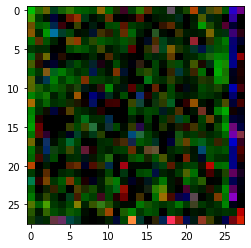

In [43]:
plt.imshow(pred_tf[0].numpy()[0][..., :3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


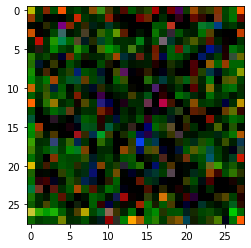

In [44]:
plt.imshow(np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1))[0][..., :3])

In [45]:
class ConvBNReLU(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        
        self.conv = keras.layers.Conv2D(
            out_chan,
            kernel_size=ks,
            strides=stride,
            padding=padding,
            use_bias=False
        )
        
        self.bn = keras.layers.BatchNormalization()

    def call(self, x):
        x = self.conv(x)
        x = K.relu(self.bn(x))
        return x
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in ["conv", "bn"]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                            keras.layers.Conv2D,
                            keras.layers.BatchNormalization,
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [46]:
class BiSeNetOutput(keras.layers.Layer):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        
        self.conv = ConvBNReLU(
            in_chan, 
            mid_chan, 
            ks=3, 
            stride=1, 
            padding="same"
        )
        self.conv_out = keras.layers.Conv2D(
#             mid_chan, 
            n_classes, 
            kernel_size=1, 
            use_bias=False
        )

    def call(self, x):
        x = self.conv(x)
        x = self.conv_out(x)
        return x
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "conv", 
            "conv_out"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                            keras.layers.Conv2D,
                            keras.layers.BatchNormalization,
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
            
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [47]:
class AttentionRefinementModule(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        
        self.conv = ConvBNReLU(
            in_chan, 
            out_chan, 
            ks=3, 
            stride=1, 
            padding="same"
        )
        
        self.conv_atten = keras.layers.Conv2D(
#           out_chan, 
            out_chan, 
            kernel_size=1, 
            use_bias=False
        )
        
        self.bn_atten = keras.layers.BatchNormalization()
        self.sigmoid_atten = keras.activations.sigmoid
        
    def call(self, x):
        feat = self.conv(x)
        
        atten = K.pool2d(feat, 
                         pool_size=feat.shape[2:3+1],
                         pool_mode="avg",
                         padding="same")
    
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        out = tf.math.multiply(feat, atten)
        return out
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "conv", 
            "conv_atten",
            "bn_atten"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                            keras.layers.Conv2D,
                            keras.layers.BatchNormalization,
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [48]:
class ContextPath(keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(ContextPath, self).__init__()
        
        self.resnet = TFResnet18()
        self.arm16 = AttentionRefinementModule(256, 128)
        self.arm32 = AttentionRefinementModule(512, 128)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding="same")
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding="same")
        self.conv_avg = ConvBNReLU(512, 128, ks=1, stride=1, padding="same")
        
    def call(self, x):
        H0, W0 = x.shape[1:2+1]
        
        feat8, feat16, feat32 = self.resnet(x)
        
        H8, W8 = feat8.shape[1:2+1]
        H16, W16 = feat16.shape[1:2+1]
        H32, W32 = feat32.shape[1:2+1]

        avg = K.pool2d(feat32, 
                       pool_size=feat32.shape[1:2+1],
                       pool_mode="avg",
                       padding="same")
        avg = self.conv_avg(avg)
        avg_up = tf.image.resize(avg, 
                                 (H32, W32), 
                                 method='nearest')

        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg_up
        feat32_up = tf.image.resize(feat32_sum, 
                                    (H16, W16), 
                                    method='nearest')
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = tf.image.resize(feat16_sum, 
                                  (H8, W8), 
                                  method='nearest')
        feat16_up = self.conv_head16(feat16_up)

        return feat8, feat16_up, feat32_up  # x8, x8, x16
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "resnet", 
            "arm16",
            "arm32",
            "conv_head32",
            "conv_head16",
            "conv_avg"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                            keras.layers.Conv2D,
                            keras.layers.BatchNormalization,
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [49]:
class FeatureFusionModule(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        
        self.convblk = ConvBNReLU(
            in_chan,
            out_chan,
            ks=1,
            stride=1,
            padding="same"
        )
        
        self.conv1 = keras.layers.Conv2D(
#             out_chan,
            out_chan//4,
            kernel_size=1,
            strides=1,
            padding="same",
            use_bias=False
        )
        self.conv2 = keras.layers.Conv2D(
#             out_chan//4,
            out_chan,
            kernel_size=1,
            strides=1,
            padding="same",
            use_bias=False
        )

    def call(self, inputs):
        fsp, fcp = inputs
        
        fcat = K.concatenate([fsp, fcp], axis=3)
        
        feat = self.convblk(fcat)
        
        atten = K.pool2d(feat, 
                         pool_size=feat.shape[1:2+1], 
                         strides=feat.shape[1:2+1], 
                         pool_mode="avg",
                         padding="same")
        atten = self.conv1(atten)
        atten = K.relu(atten)
        atten = self.conv2(atten)
        atten = K.sigmoid(atten)
        
        feat_atten = tf.math.multiply(feat, atten)
        
        feat_out = feat_atten + feat
        return feat_out
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "convblk", 
            "conv1",
            "conv2",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                            keras.layers.Conv2D,
                            keras.layers.BatchNormalization,
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [50]:
class TFBiSeNet(keras.models.Model):
    def __init__(self, n_classes, *args, **kwargs):
        super(TFBiSeNet, self).__init__()
        
        self.cp = ContextPath()
        ## here self.sp is deleted
        
        self.ffm = FeatureFusionModule(256, 256)
        
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(128, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(128, 64, n_classes)

    def call(self, x):
        H, W = x.shape[1:2+1]
    
        feat_res8, feat_cp8, feat_cp16 = self.cp(x)  # here return res3b1 feature
        
        feat_sp = feat_res8  # use res3b1 feature to replace spatial path feature
        feat_fuse = self.ffm((feat_sp, feat_cp8))

        feat_out = self.conv_out(feat_fuse)
        feat_out16 = self.conv_out16(feat_cp8)
        feat_out32 = self.conv_out32(feat_cp16)

        feat_out = tf.image.resize(feat_out, 
                                   (H, W), 
                                   method='bilinear')
        feat_out16 = tf.image.resize(feat_out16, 
                                     (H, W), 
                                     method='bilinear')
        feat_out32 = tf.image.resize(feat_out32, 
                                     (H, W), 
                                     method='bilinear')
        
        return feat_out, feat_out16, feat_out32
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "cp", 
            "ffm",
            "conv_out",
            "conv_out16",
            "conv_out32",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict, 1)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                            keras.layers.Conv2D,
                            keras.layers.BatchNormalization,
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [51]:
model_state_dict = torch.load(os.path.join("res/cp", "79999_iter.pth"))

print(f"{'Parameter':80s}Size")
print("-" * 100)
for k, v in model_state_dict.items():
    print(f"{k:80s}{list(v.shape)}")

Parameter                                                                       Size
----------------------------------------------------------------------------------------------------
cp.resnet.conv1.weight                                                          [64, 3, 7, 7]
cp.resnet.bn1.weight                                                            [64]
cp.resnet.bn1.bias                                                              [64]
cp.resnet.bn1.running_mean                                                      [64]
cp.resnet.bn1.running_var                                                       [64]
cp.resnet.bn1.num_batches_tracked                                               []
cp.resnet.layer1.0.conv1.weight                                                 [64, 64, 3, 3]
cp.resnet.layer1.0.bn1.weight                                                   [64]
cp.resnet.layer1.0.bn1.bias                                                     [64]
cp.resnet.layer1.0.bn1.running_m

In [52]:
net = load_pytorch_model()

In [53]:
net.load_state_dict(model_state_dict)

<All keys matched successfully>

In [54]:
net.eval()

BiSeNet(
  (cp): ContextPath(
    (resnet): Resnet18(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [55]:
net_tf = TFBiSeNet(n_classes=19)

In [57]:
in_ten = torch.randn(2, 3, 640, 480)

In [58]:
out, out16, out32 = net(in_ten)

print(f"out.shape: {out.shape}")
print(f"out16.shape: {out16.shape}")
print(f"out32.shape: {out32.shape}")

out.shape: torch.Size([2, 19, 640, 480])
out16.shape: torch.Size([2, 19, 640, 480])
out32.shape: torch.Size([2, 19, 640, 480])


In [59]:
out_tf, out16_tf, out32_tf = net_tf(in_ten.permute(0, 2, 3, 1).detach().numpy())

In [60]:
net_tf.load_weights_pytorch(model_state_dict)

TFBiSeNet: Setting weight for layer: cp, type: ContextPath
TFBiSeNet: layer_state_dict keys: ['resnet.conv1.weight', 'resnet.bn1.weight', 'resnet.bn1.bias', 'resnet.bn1.running_mean', 'resnet.bn1.running_var', 'resnet.bn1.num_batches_tracked', 'resnet.layer1.0.conv1.weight', 'resnet.layer1.0.bn1.weight', 'resnet.layer1.0.bn1.bias', 'resnet.layer1.0.bn1.running_mean', 'resnet.layer1.0.bn1.running_var', 'resnet.layer1.0.bn1.num_batches_tracked', 'resnet.layer1.0.conv2.weight', 'resnet.layer1.0.bn2.weight', 'resnet.layer1.0.bn2.bias', 'resnet.layer1.0.bn2.running_mean', 'resnet.layer1.0.bn2.running_var', 'resnet.layer1.0.bn2.num_batches_tracked', 'resnet.layer1.1.conv1.weight', 'resnet.layer1.1.bn1.weight', 'resnet.layer1.1.bn1.bias', 'resnet.layer1.1.bn1.running_mean', 'resnet.layer1.1.bn1.running_var', 'resnet.layer1.1.bn1.num_batches_tracked', 'resnet.layer1.1.conv2.weight', 'resnet.layer1.1.bn2.weight', 'resnet.layer1.1.bn2.bias', 'resnet.layer1.1.bn2.running_mean', 'resnet.layer1.1.b

In [61]:
out_tf, out16_tf, out32_tf = net_tf(in_ten.permute(0, 2, 3, 1).detach().numpy())

In [62]:
print(f"out_tf.shape: {out_tf.shape}")
print(f"out16_tf.shape: {out16_tf.shape}")
print(f"out32_tf.shape: {out32_tf.shape}")

out_tf.shape: (2, 640, 480, 19)
out16_tf.shape: (2, 640, 480, 19)
out32_tf.shape: (2, 640, 480, 19)


In [63]:
net_tf.summary()

Model: "tf_bi_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
context_path (ContextPath)   multiple                  12467648  
_________________________________________________________________
feature_fusion_module (Featu multiple                  99328     
_________________________________________________________________
bi_se_net_output (BiSeNetOut multiple                  595712    
_________________________________________________________________
bi_se_net_output_1 (BiSeNetO multiple                  75200     
_________________________________________________________________
bi_se_net_output_2 (BiSeNetO multiple                  75200     
Total params: 13,313,088
Trainable params: 13,300,416
Non-trainable params: 12,672
_________________________________________________________________


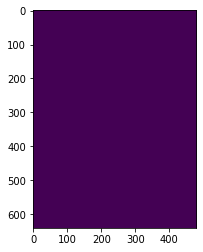

In [64]:
plt.imshow(np.argmax(out.permute(0, 2, 3, 1)[0].detach().numpy(), -1))

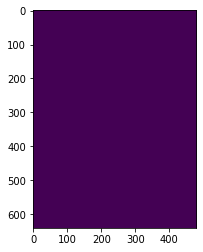

In [65]:
plt.imshow(np.argmax(out_tf[0].numpy(), -1))